# Introduction
This notebook serves as documentation for the creation of a regression model with CO2 emmision as the target variable. The notebook explores and compares several regression models, including ridge regression, elastic net regression, KNN regression, and decision tree regression. The evaluation metrics used to assess the models' performance are R² (coefficient of determination) and mean absolute error.

Towards the end of the notebook, feature explanations are provided using the SHAP (SHapley Additive exPlanations) library. SHAP allows for a deeper understanding of the impact and importance of different features in the regression model.

Overall, this notebook provides a comprehensive overview of the regression model creation process, model evaluation, and feature explanation using the SHAP library.

This is the last one of three notebooks.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Read the CSV file into a DataFrame
df = pd.read_csv(os.path.join(current_directory, "df_final.csv"))

In [3]:
# Convert categorical variables from integer to string
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(str)
df['ZipCode'] = df['ZipCode'].astype(str)
df=df[~df['TotalGHGEmissions_log'].isin([np.inf,-np.inf])].copy()

In [4]:
# Define X and y
X = df[[
    'PrimaryPropertyType', 'ZipCode', 'Neighborhood', 'CouncilDistrictCode',
    'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFAParking', 'LargestPropertyUseType',  'ENERGYSTARScore', 'BuildingAge',
    'parking_area_prcnt', 'PropertyGFATotal_log', 'PropertyGFABuilding(s)_log', 'LargestPropertyUseTypeGFA_log'
]].copy()

y = df['TotalGHGEmissions_log']

## Preprocessing

In [5]:
# Initiate column transformer (with one-hot encoder)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_transform = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"),
     ["PrimaryPropertyType", "ZipCode", 'Neighborhood', 'CouncilDistrictCode', 'LargestPropertyUseType']),
    remainder="passthrough"
)

# Initiate StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Models

In [6]:
# Split the dataset (30% test size)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Import packages 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [8]:
# Define the candidate parameters for the chosen models
params_ridge = {"ridge__alpha": np.logspace(-5, 5, 5)}
params_net = {"elasticnet__alpha": np.logspace(-5, 5, 5)}
params_knn = {"kneighborsregressor__n_neighbors": [3, 10, 30]}
params_tree = {
    "decisiontreeregressor__min_samples_leaf": [10, 30, 50],
    "decisiontreeregressor__max_depth": [10, 30, 50],
}
params = [params_ridge, params_net, params_knn, params_tree]

In [9]:
# Find the best parameters with GridSearchCV and pipeline
models = [
    Ridge(random_state=42, tol=0.1),
    ElasticNet(random_state=42, tol=1),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=42),
]

best_params = []
for model, param in zip(models, params):
    pipe = make_pipeline(col_transform, scaler, model)
    grid = GridSearchCV(pipe, param, cv=5, scoring="neg_mean_absolute_error")
    grid.fit(X_train, y_train)
    best_params.append(grid.best_params_)

# The best parameters...
best_params

[{'ridge__alpha': 1e-05},
 {'elasticnet__alpha': 0.0031622776601683794},
 {'kneighborsregressor__n_neighbors': 30},
 {'decisiontreeregressor__max_depth': 10,
  'decisiontreeregressor__min_samples_leaf': 50}]

In [10]:
# Plug in the best parameters
names = ["ridge_regression", "elastic_net_regression", "knn_regression", "decision_tree_regression"]

models_best_params = [
    Ridge(random_state=42, tol=0.1, alpha=best_params[0]["ridge__alpha"]),
    ElasticNet(random_state=42, tol=0.1, alpha=best_params[1]["elasticnet__alpha"]),
    KNeighborsRegressor(n_neighbors=best_params[2]["kneighborsregressor__n_neighbors"]),
    DecisionTreeRegressor(
        random_state=42,
        max_depth=best_params[3]["decisiontreeregressor__max_depth"],
        min_samples_leaf=best_params[3]["decisiontreeregressor__min_samples_leaf"],
    ),
]

In [11]:
# Create a dataset for plotting predictions
result_viz = pd.DataFrame(y_test)
result_viz.columns = ['target']

In [12]:
# Obtain train and test scores, as well as MAE (mean absolute error) for each model
train_score_r2 = []
test_score_r2 = []
train_mae = []
test_mae = []

for model, name in zip(models_best_params, names):
    pipe = make_pipeline(col_transform, scaler, model)
    score_train = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2").mean()
    score_test = cross_val_score(pipe, X_test, y_test, cv=5, scoring="r2").mean()
    mae_train = np.abs(
        cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    )
    mae_test = np.abs(
        cross_val_score(pipe, X_test, y_test, cv=5, scoring="neg_mean_absolute_error").mean()
    )

    test_score_r2.append(score_test)
    train_score_r2.append(score_train)
    train_mae.append(mae_train)
    test_mae.append(mae_test)

    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)
    result_viz[name] = predict

In [13]:
# Create results metrics table
results = {'model': names}
results['train_score_r2'] = train_score_r2
results['test_score_r2'] = test_score_r2
results['train_mean_absolute_error'] = train_mae
results['test_mean_absolute_error'] = test_mae

In [14]:
# Convert results to a DataFrame
model_scores = pd.DataFrame(results)
model_scores = round(model_scores, 2)
model_scores.sort_values(by='test_score_r2', ascending=False)

,model,train_score_r2,test_score_r2,train_mean_absolute_error,test_mean_absolute_error
1,elastic_net_regression,0.48,0.47,0.78,0.88
0,ridge_regression,0.47,0.42,0.79,0.91
3,decision_tree_regression,0.40,0.40,0.86,0.94
2,knn_regression,0.24,0.31,0.95,1.01


Based on the analysis conducted, the elastic net regression model outperforms the other models, exhibiting the highest determination score and the lowest mean absolute error. Thus, it can be concluded that the elastic net regression model is the superior choice among the four models evaluated.

In [15]:
# Sort and display the predicted values on the test set
result_viz = result_viz.sort_values(by="target")
result_viz.reset_index(drop=True, inplace=True)
result_viz.head()

,target,ridge_regression,elastic_net_regression,knn_regression,decision_tree_regression
0,0.113329,2.748615,2.735489,3.687399,2.845945
1,0.215111,2.204544,2.159276,3.009884,2.752325
2,0.463734,2.389755,2.372177,3.594776,2.845945
3,0.470004,1.250838,1.176141,2.749107,2.743156
4,0.518794,2.552784,2.579224,3.681572,2.845945


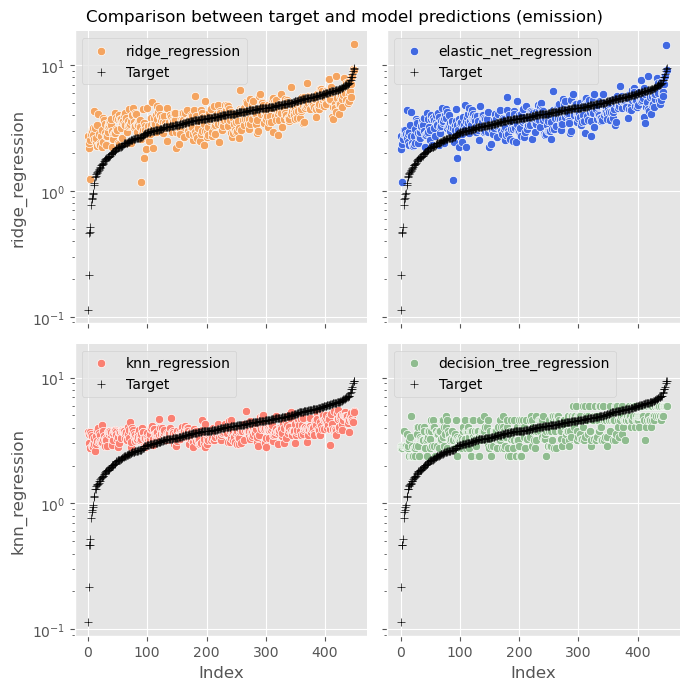

In [16]:
colors = ["sandybrown", "royalblue", "salmon", "darkseagreen"]
cols = ['ridge_regression', 'elastic_net_regression', 'knn_regression', 'decision_tree_regression']

plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(7, 7))
for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(data=result_viz, x=result_viz.index, y=result_viz[cols[i]], color=colors[i], label=cols[i], ax=ax)
    sns.scatterplot(data=result_viz, x=result_viz.index, y=result_viz["target"], color="black", label="Target", marker="+", ax=ax)

    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Index')
    ax.set_yscale("log")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Comparison between target and model predictions (emission)")
plt.savefig('scatter_plot_results_compare_emission', bbox_inches='tight', dpi=300)
plt.show()

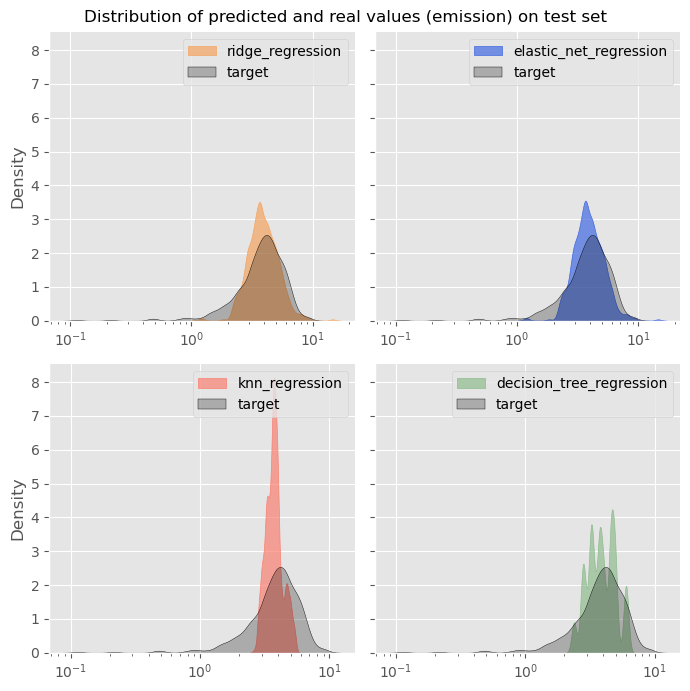

In [17]:
# Distribution of predictions and target values
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(7, 7))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(result_viz[cols[i]], shade=True, log_scale=True, bw_adjust=0.6,
                color=colors[i], ax=ax, label=cols[i], linewidth=0.5, alpha=0.7)
    sns.kdeplot(result_viz['target'], shade=True, log_scale=True, bw_adjust=0.6,
                color='black', ax=ax, label='target', linewidth=0.3)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Distribution of predicted and real values (emission) on test set")
plt.savefig('kde_plot_results_compare_emission', bbox_inches='tight', dpi=300)
plt.show()

## Model interpretation

In [18]:
# Transforming the features using one-hot encoding
X_one_hot_encoded = pd.DataFrame(col_transform.fit_transform(X), columns=col_transform.get_feature_names_out())
X_ohe_scaled = pd.DataFrame(scaler.fit_transform(X_one_hot_encoded), columns=X_one_hot_encoded.columns)

# Obtaining the alpha value for ElasticNet from the best_params dictionary
alpha_net = best_params[1]['elasticnet__alpha']

# Fitting the ElasticNet regression model
elastic_net = ElasticNet(alpha=alpha_net, random_state=42, tol=0.1).fit(X_ohe_scaled, y)


In [19]:
# Creating an explainer object for the ElasticNet model
import shap

explainer_net = shap.Explainer(elastic_net.predict, X_ohe_scaled)
shap_values_net = explainer_net(X_ohe_scaled)

Permutation explainer: 1499it [00:34, 32.65it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


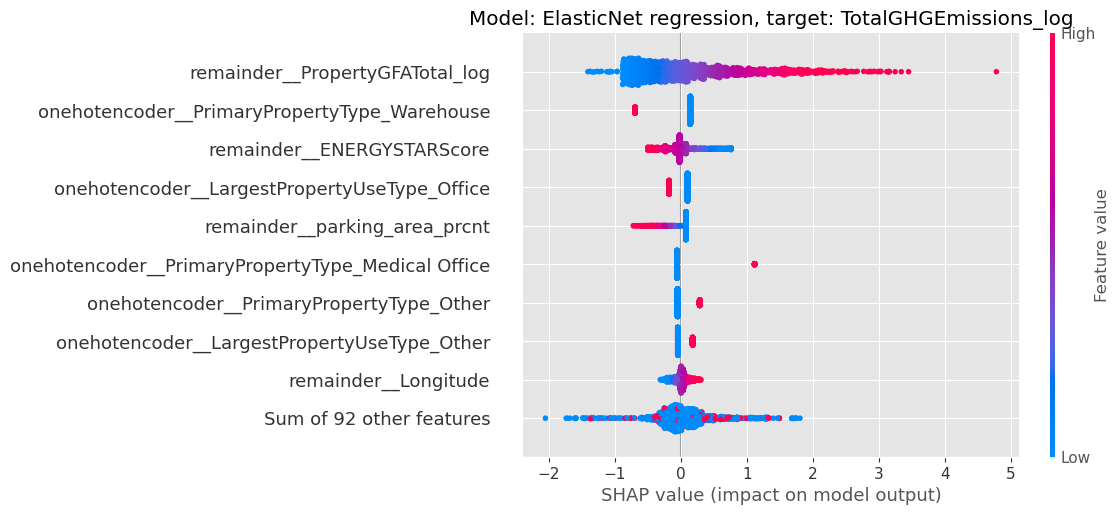

In [20]:
# Generating a beeswarm plot of the SHAP values
fig = shap.plots.beeswarm(shap_values_net, max_display=10, show=False)
plt.title('Model: ElasticNet regression, target: TotalGHGEmissions_log')
plt.savefig('shap_plot_net_beeswarm_emission', dpi=300, bbox_inches='tight')
plt.show()

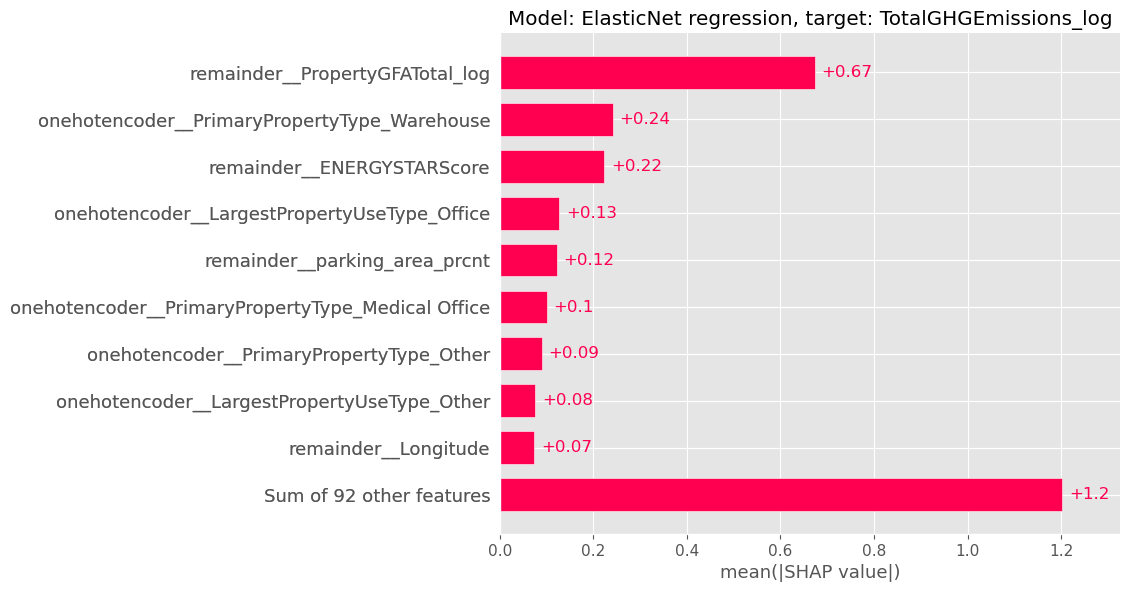

In [21]:
# Generating a bar plot of the SHAP values
fig = shap.plots.bar(shap_values_net, max_display=10, show=False)
plt.title('Model: ElasticNet regression, target: TotalGHGEmissions_log')
plt.savefig('shap_plot_net_bar_emission', dpi=300, bbox_inches='tight')
plt.show()

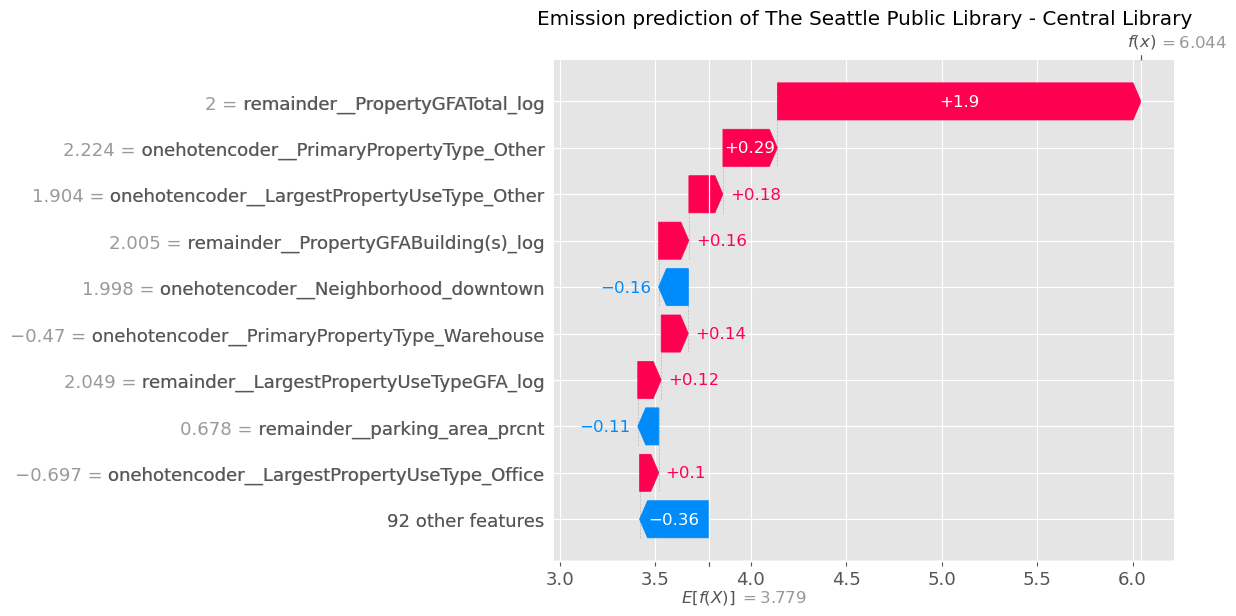

In [22]:
# Generating a waterfall plot for an individual sample
shap.plots.waterfall(shap_values_net[2], show=False)
plt.title(f"Emission prediction of {df.loc[2, 'PropertyName']}")
plt.savefig('shap_plot_bar_indiv_emission', bbox_inches='tight', dpi=300)
plt.show()

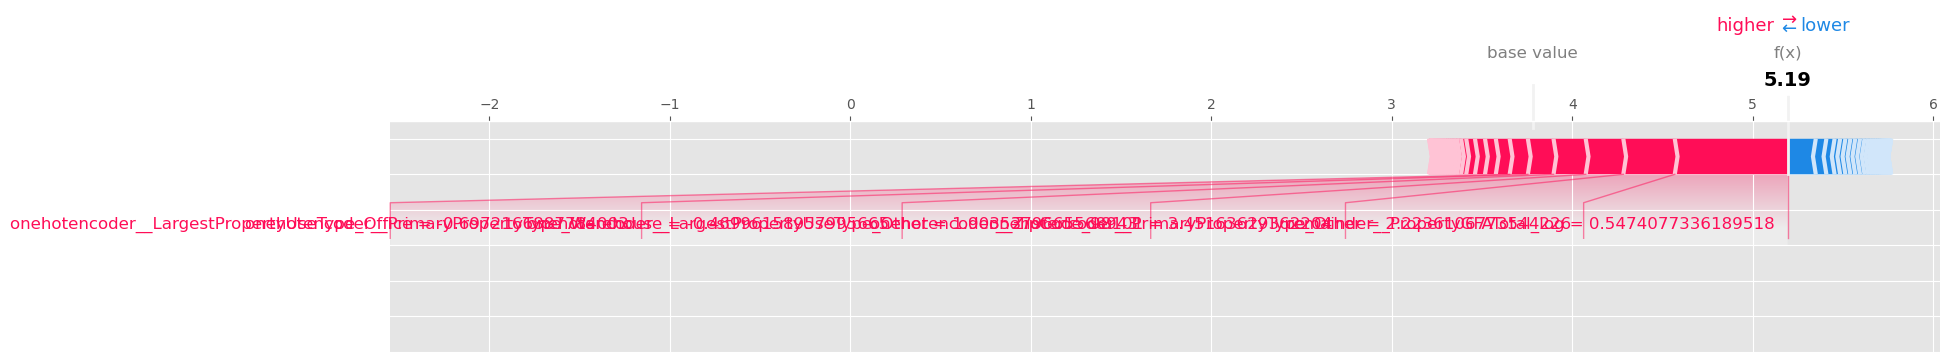

In [23]:
# Initializing the JS visualization and generating a force plot
shap.initjs()
fig = shap.plots.force(shap_values_net[1], matplotlib=True)

## ENERGYStarScore

In [24]:
# Creating two versions of X: one with ENERGYSTARScore and one without
X_with_var = X.copy()
X_without_var = X.drop(columns='ENERGYSTARScore')
y = df['TotalGHGEmissions_log']

In [25]:
# Creating a pipeline with the chosen model (ElasticNet) and the best alpha value
pipe = make_pipeline(col_transform, scaler, ElasticNet(alpha=alpha_net, random_state=42, tol=0.1))

# Calculating the R² scores with and without ENERGYSTARScore
score_r2_with_var = cross_val_score(pipe, X_with_var, y, cv=5, scoring="r2").mean()
score_r2_without_var = cross_val_score(pipe, X_without_var, y, cv=5, scoring="r2").mean()

In [26]:
# Printing the results
print('Score R² ridge regression avec ENERGYSTARScore:', np.around(score_r2_with_var, 4))
print('Score R² ridge regression sans ENERGYSTARScore:', np.around(score_r2_without_var, 4))
print('Difference between the results:', np.around(np.diff([score_r2_with_var, score_r2_without_var]), 4))

Score R² ridge regression avec ENERGYSTARScore: 0.4353
Score R² ridge regression sans ENERGYSTARScore: 0.3903
Difference between the results: [-0.0451]


The above result shows that ENERGYSTARScore improves the model's performance by 4.42%. <br>
End of the project. Thank you.